# step 2 Fit the zernike model  

In [3]:
from IPython.display import Image

Zernike polynimals are used to describe the distortion feild. A distortion feild can be represneted by linar combination of Zernike terms. 

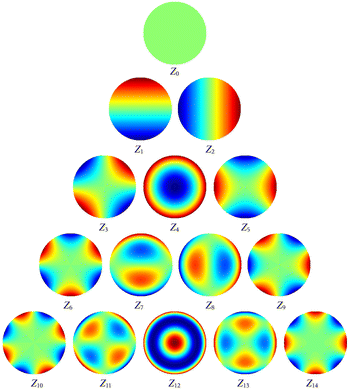

In [4]:
Image(filename = 'Zernike.png', width=400, height=400)

Zernike polynomials are defined in polar coordination, therefore it is necessary to define the distortion by Zernike terms in cartesian coordination. 

For the Zernike polynomials in the Cartesian coordination, the wave aberration W(x,y) can be expressed by equation:

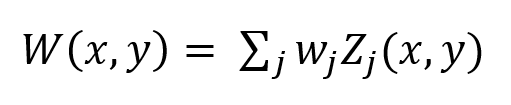

In [3]:
Image(filename = 'equation1.png', width=200, height=200)

where wj are the Zernike expansion coefficients and Zj(x,y) are the Zernike polynomials in Cartesian coordination. 
ε_x (x,y) and ε_y (x,y)  are the x-component and y-component displacement from the ideal points to actual points. 
The displacement also can be described by the Zernike model:

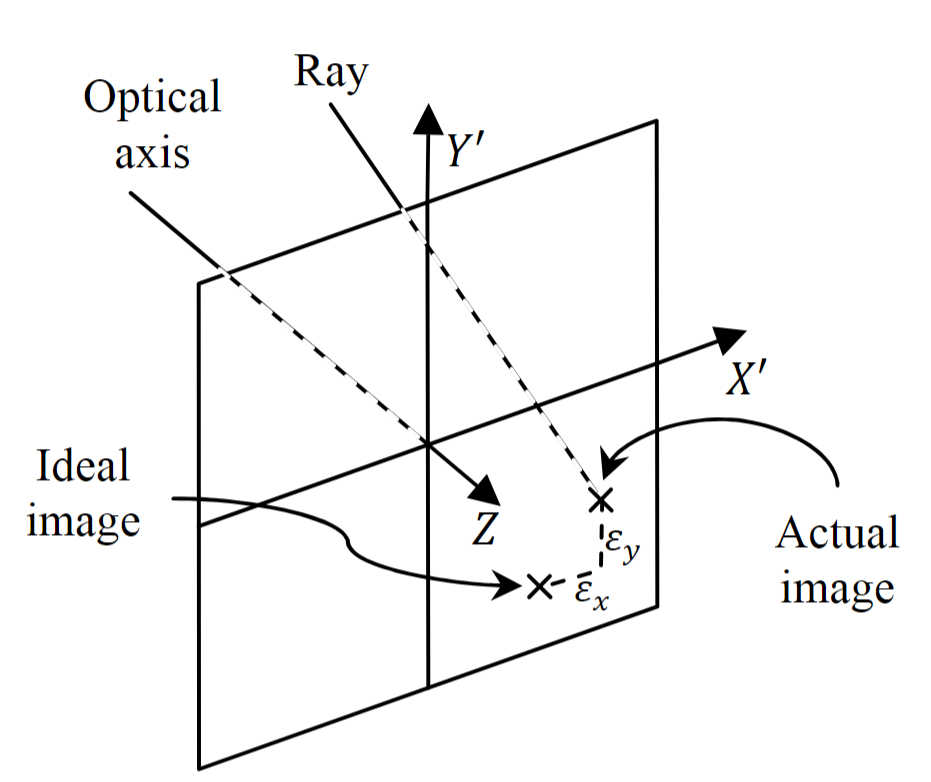

In [4]:
Image(filename = 'schematic.png', width=400, height=400)

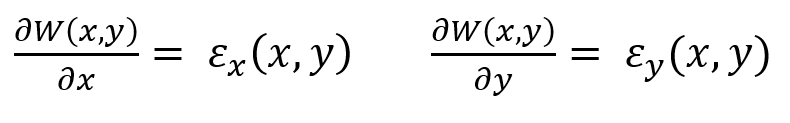

In [5]:
Image(filename = 'equation2.png', width=350, height=350)

The component of displacement can be expressed by the combination of the component of Zernike polynomials with the same Zernike parameters.

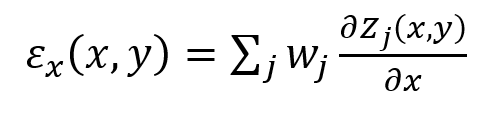

In [6]:
Image(filename = 'equation3.png', width=200, height=200)

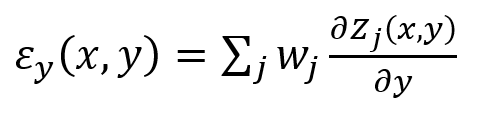

In [7]:
Image(filename = 'equation4.png', width=200, height=200)

Then least square method is used to fit the Zernike parameters. Target function is the sum of difference between discrete displacement map field and continuous displacement map generate by Zernike model at x direction and y direction.

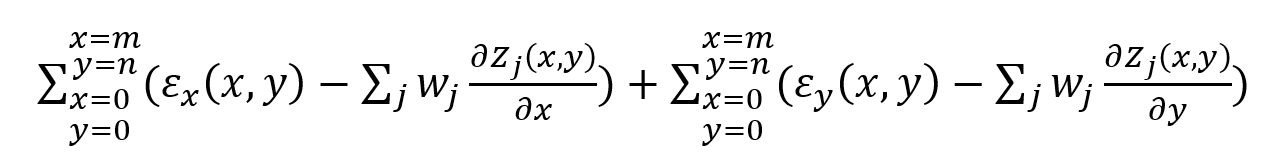

In [8]:
Image(filename = 'equation5.png', width=500, height=500)

Then pacbed image is corrected by remapping method based on the fittet distortion feild. During the process, to avoid edge artifacts caused by circular shape of zernike terms, the image is put into the center of a larger image. The size of large image can be adjust to get better fitting results.   

### Import libaries

In [2]:
import cv2
import math
import imutils
import argparse 
import numpy as np
import hyperspy.api as hs
import zernike
from zernike import RZern
from skimage import measure
from scipy import optimize
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import hsv_to_rgb
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy.linalg import lstsq

### Step 2.1 Load data

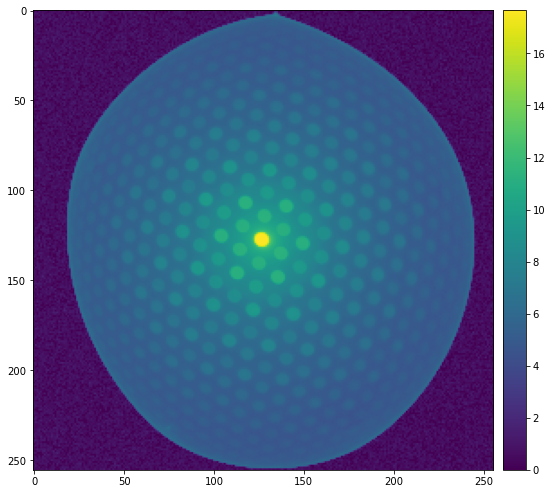

In [3]:
# load the pacbed image
folder = "E:/Nion_PL_aberr_20231023/5_15/"
cbed_image = np.load(folder + "pacbed.npy")
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.log(cbed_image*10000+1), cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
#grid[0].set_title("CBED")
cbed_image = np.log(cbed_image*10000+1)

In [7]:
# Function to estimate the undistorted position of disks
# params: array of parameters for the transformation
# cell_pos: array of current cell positions
# cell_coord: array of cell coordinates
def estimatedPos(params, cell_pos, cell_coord):
    # Initialize an array to hold the new peak positions
    new_peak = np.zeros_like(cell_pos)
    
    # Iterate over each cell position
    for i in range(cell_pos.shape[0]):
        # Calculate the new peak position using the parameters and coordinates
        new_peak[i] = params[4:6] + cell_coord[i, 0]*params[0:2] + cell_coord[i, 1]*params[2:4]
    
    # Return the new peak positions
    return new_peak

# Function to calculate the target function value
# params: array of parameters for the transformation
# cell_pos: array of current cell positions
# cell_coord: array of cell coordinates
def targetFun(params, cell_pos, cell_coord):
    # Estimate the new peak positions
    new_peak = estimatedPos(params, cell_pos, cell_coord)
    
    # Calculate and return the sum of squared differences between current and new positions
    return np.sum((cell_pos - new_peak)**2)

# Alternative function to estimate the undistorted position of disks using a fixed reference cell position (cell0)
# params: array of parameters for the transformation
# cell0: reference cell position
# cell_pos: array of current cell positions
# cell_coord: array of cell coordinates
def estimatedPos1(params, cell0, cell_pos, cell_coord):
    # Initialize an array to hold the new peak positions
    new_peak = np.zeros_like(cell_pos)
    
    # Iterate over each cell position
    for i in range(cell_pos.shape[0]):
        # Calculate the new peak position using the reference cell position, parameters, and coordinates
        new_peak[i] = cell0 + cell_coord[i, 0]*params[0:2] + cell_coord[i, 1]*params[2:4]
    
    # Return the new peak positions
    return new_peak

# Alternative function to calculate the target function value using a fixed reference cell position (cell0)
# params: array of parameters for the transformation
# cell0: reference cell position
# cell_pos: array of current cell positions
# cell_coord: array of cell coordinates
def targetFun1(params, cell0, cell_pos, cell_coord):
    # Estimate the new peak positions
    new_peak = estimatedPos1(params, cell0, cell_pos, cell_coord)
    
    # Calculate and return the sum of squared differences between current and new positions
    return np.sum((cell_pos - new_peak)**2)

Text(0.5, 1.0, 'grad')

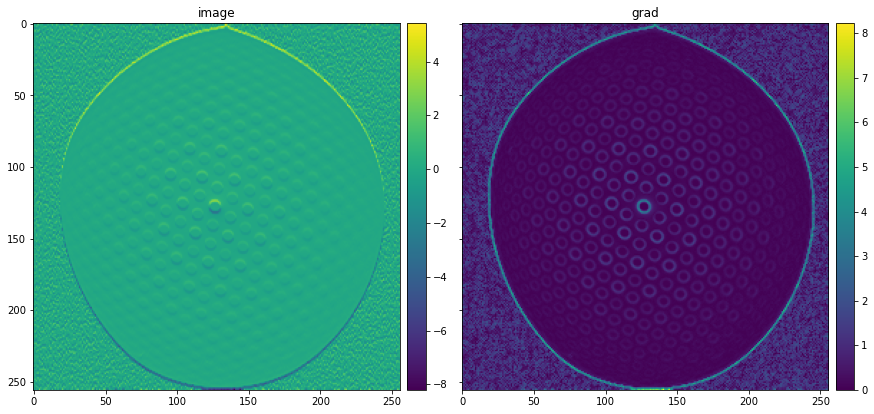

In [8]:
# get the outline of disks
img_gradx, img_grady = np.gradient(gray)
img_grad = np.sqrt(np.square(img_gradx)+np.square(img_grady))
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(img_gradx, cmap=plt.cm.viridis)
im2=grid[1].imshow(img_grad, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("image")
grid[1].set_title("grad")

In [9]:
#remove the outline of pattern
center_mask = np.zeros(gray.shape)
Y, X = np.indices(gray.shape)
x_center = gray.shape[0]/2
y_center = gray.shape[1]/2
radius_cm =gray.shape[0]*0.3  #radius of center mask to project the central disks
center_mask[np.where(np.sqrt((X-x_center)**2 + (Y-y_center)**2)>radius_cm)] = 1.0
gray_masked = img_grad*center_mask
out_thresh = gray.max()*0.3 #threshhold of the remianed singal value 
img_grad[np.where(gray_masked>out_thresh)] = 0

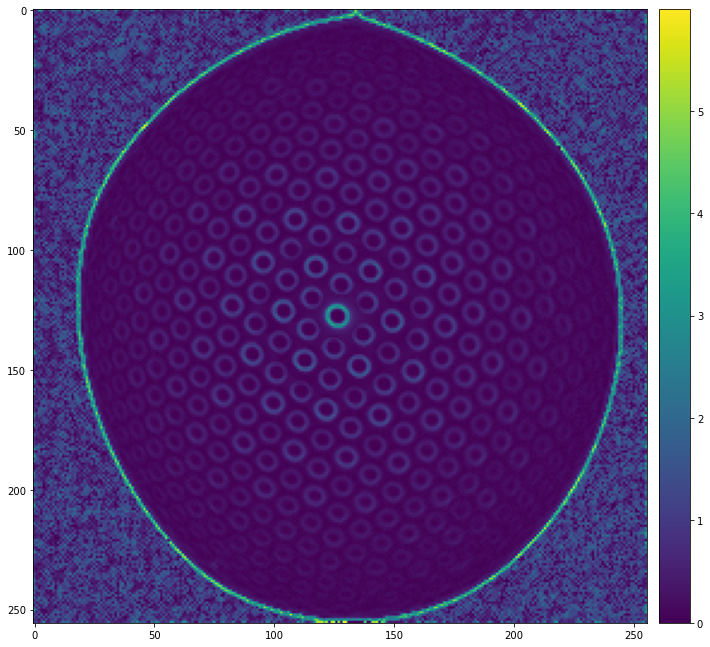

In [10]:
# check the result
fig =plt.figure(1, figsize=(40, 40))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(img_grad, cmap=plt.cm.viridis) 
grid.cbar_axes[0].colorbar(im)

In [13]:
# Load the centers of disks
centers =np.load(folder +'BJ_515_centers_4.npy')
sub_peak = np.zeros(centers.shape)
sub_peak[:,0] = centers[:,1]
sub_peak[:,1] = centers[:,0]

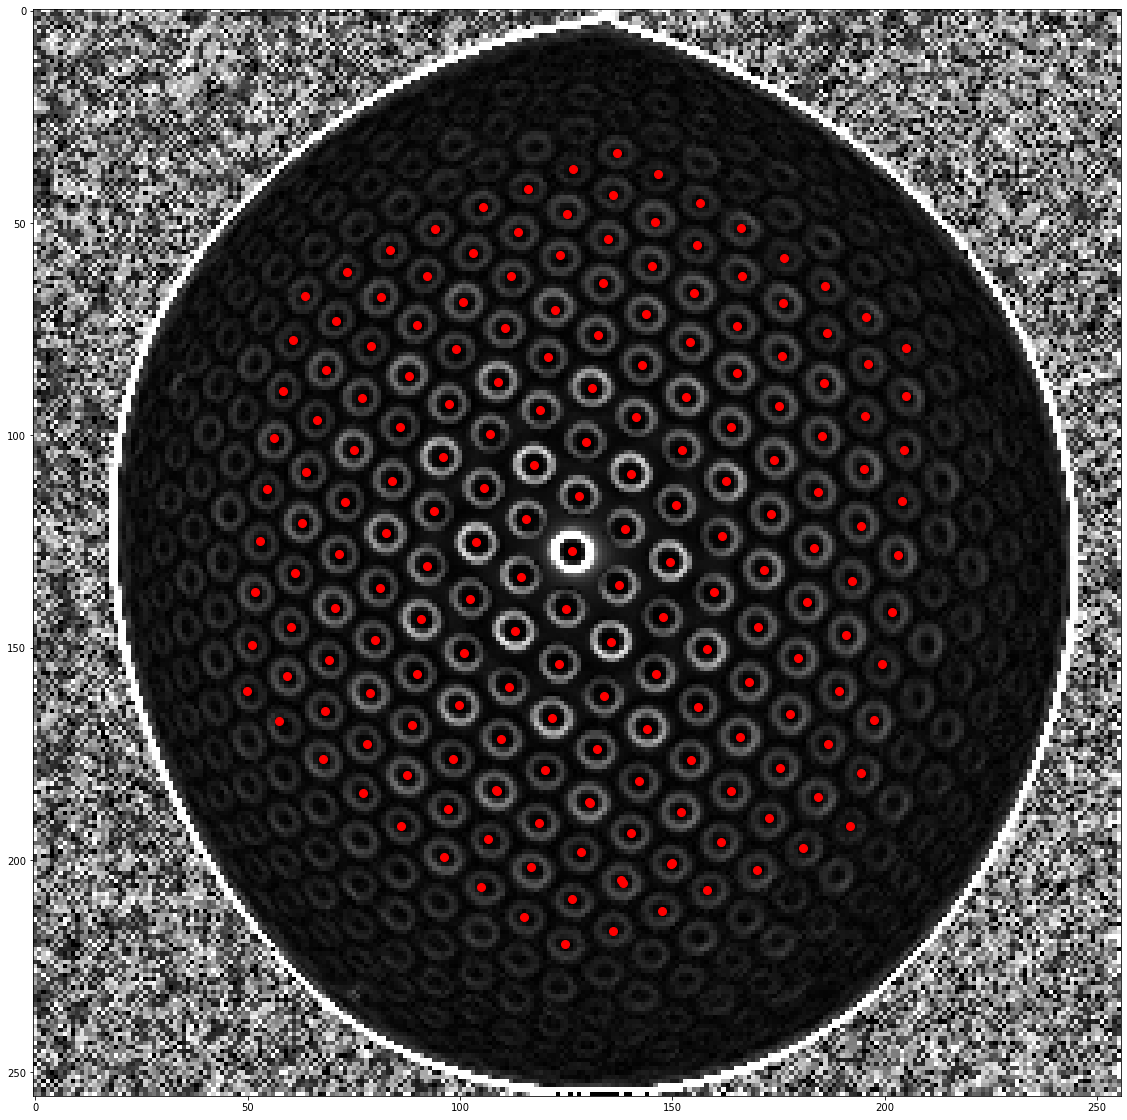

In [14]:
# Plot the centers
EMData = np.float32(img_grad)
rgb_frame=cv2.cvtColor(EMData/np.max(EMData)*3, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame)
plt.plot(sub_peak[:,1],sub_peak[:,0],'red',marker = 'o',linestyle = '',markersize = 8)

### Step 2.2  Estimate the undistorted position

In [15]:
# Estimate the undistorted lattice based on center positions

In [16]:
# determine two basic vectors of the lattice
x_pos = EMData.shape[0]/2
y_pos = EMData.shape[1]/2
#find the nearest unit cell around this position
dist_mat = distance_matrix(sub_peak,np.asarray([[y_pos, x_pos], ]))
center_idx= np.argmin(dist_mat, axis=0)
cell0 = sub_peak[center_idx][0]
#find the atom columns closest to cell zero.
dist_mat = distance_matrix(sub_peak,np.asarray([[cell0[0], cell0[1]], ]))
dist_idx = np.argsort(dist_mat, axis=0)
#pick up the first 6 and determine the vector, select the vector with large intersection angle.
vector1 = sub_peak[dist_idx[1]] - sub_peak[dist_idx[0]]
for i in range(4):
    vector2 = sub_peak[dist_idx[2+i]] - sub_peak[dist_idx[0]]
    angle = np.sum(vector1*vector2)
    if angle < 0:
        vector2 = -vector2
    #compute the intersection angle.
    angle = np.arccos(np.abs(angle)/(np.sqrt(np.sum(vector1**2))*np.sqrt(np.sum(vector2**2))))
    if angle > 0.4:
        break
print(vector1)
print(vector2)

[[-12.96623377   1.66233766]]
[[ -7.6309295  -10.65736495]]


In [17]:
# Calculate the cell coordnations to locate each point in a hexagonal 
cell_coord = np.zeros(sub_peak.shape, np.int8)
cell_status = np.zeros(sub_peak.shape[0], np.int8)
#the center cell should be marked as 1
dist_thresh = 6.0
cell_status[center_idx] = 1
while(len(np.where(cell_status==0)[0])>0):
    for i in range(sub_peak.shape[0]):
        if cell_status[i]==1:
            cell_status[i] = 2
            #the first point
            dist_mat = distance_matrix(sub_peak,sub_peak[i]+vector1)
            min_vals = np.min(dist_mat, axis=0)
            min_idx = np.argmin(dist_mat, axis=0)
            if(min_vals<dist_thresh)&(cell_status[min_idx[0]]==0):
                cell_status[min_idx[0]] = 1
                cell_coord[min_idx[0]] = cell_coord[i]
                cell_coord[min_idx[0], 0] += 1
            #the second point
            dist_mat = distance_matrix(sub_peak,sub_peak[i]-vector1)
            min_vals = np.min(dist_mat, axis=0)
            min_idx = np.argmin(dist_mat, axis=0)
            if(min_vals<dist_thresh)&(cell_status[min_idx[0]]==0):
                cell_status[min_idx[0]] = 1
                cell_coord[min_idx[0]] = cell_coord[i]
                cell_coord[min_idx[0], 0] -= 1
            #the third point
            dist_mat = distance_matrix(sub_peak,sub_peak[i]+vector2)
            min_vals = np.min(dist_mat, axis=0)
            min_idx = np.argmin(dist_mat, axis=0)
            if(min_vals<dist_thresh)&(cell_status[min_idx[0]]==0):
                cell_status[min_idx[0]] = 1
                cell_coord[min_idx[0]] = cell_coord[i]
                cell_coord[min_idx[0], 1] += 1
            #the fourth point
            dist_mat = distance_matrix(sub_peak,sub_peak[i]-vector2)
            min_vals = np.min(dist_mat, axis=0)
            min_idx = np.argmin(dist_mat, axis=0)
            if(min_vals<dist_thresh)&(cell_status[min_idx[0]]==0):
                cell_status[min_idx[0]] = 1
                cell_coord[min_idx[0]] = cell_coord[i]
                cell_coord[min_idx[0], 1] -= 1

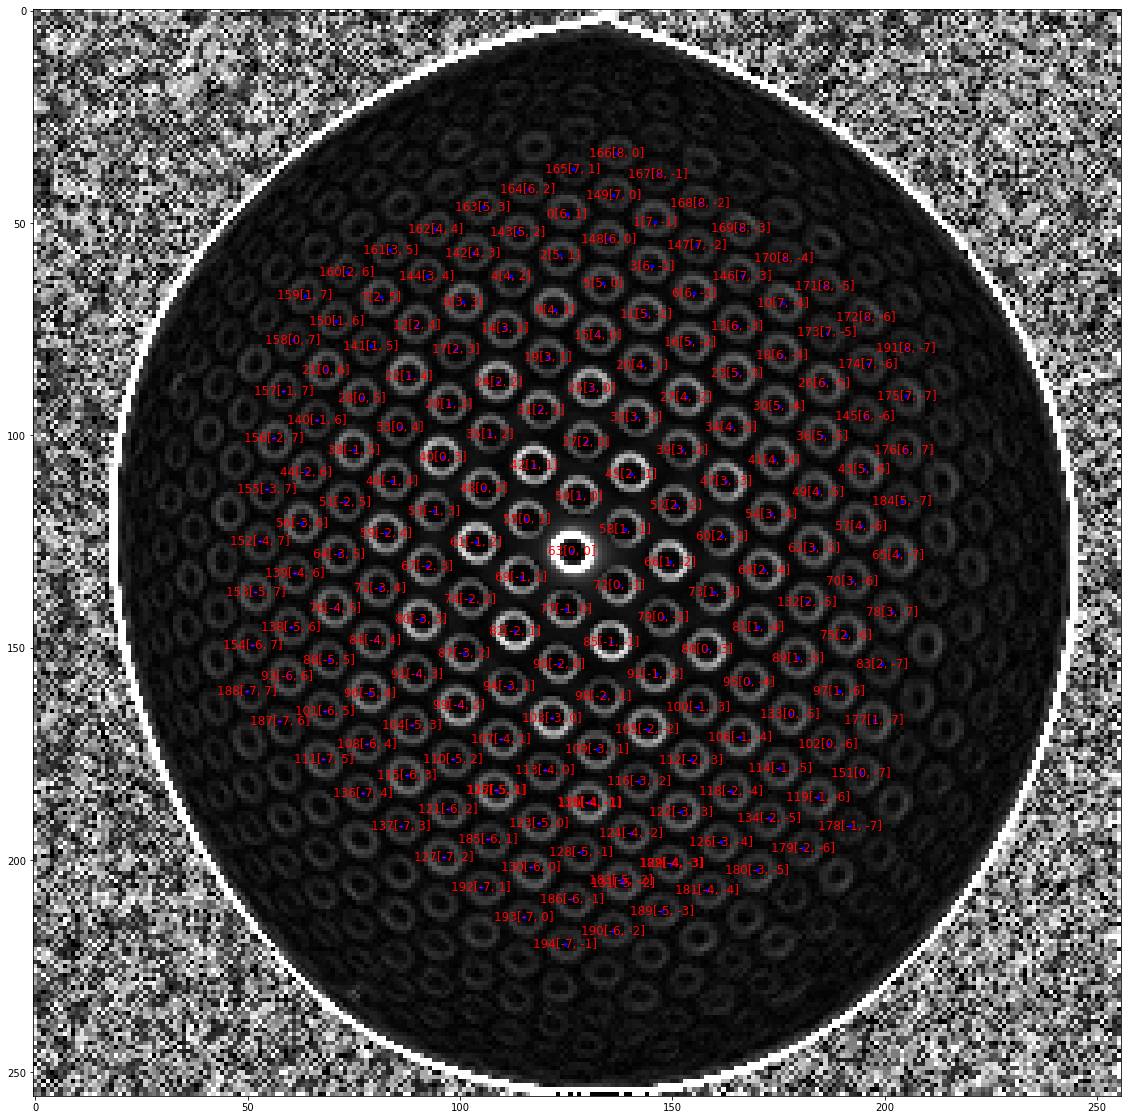

In [18]:
# check wether the cell coordinations are correct 
params1 = np.concatenate((vector1[0], vector2[0]))
new_peak = estimatedPos1(params1, cell0, sub_peak, cell_coord)
rgb_frame=cv2.cvtColor(EMData/np.max(EMData)*3, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame)
plt.scatter(sub_peak[:, 1], sub_peak[:, 0], c='b', marker='.')
for i in range(new_peak.shape[0]):
    plt.text(sub_peak[i,1],sub_peak[i,0], f'{i}[{cell_coord[i][0]}, {cell_coord[i][1]}]', fontsize=12, color = 'r',ha='center', va='center')


In [19]:
# Save the cell coordinations  
np.save(folder +'cell_coord_515.npy',cell_coord)

In [24]:
# Relod the cell coordinations if necessary
params1 = np.concatenate((vector1[0], vector2[0]))
cell_coord = np.load(folder +'cell_coord_515.npy')

In [20]:
# Estimate the undistorted lattice 
new_params = optimize.minimize(targetFun1,params1,args=(cell0,sub_peak,cell_coord), method='Nelder-Mead').x
print(new_params)
print(params1)
basis_vector1 = new_params[0:2]
basis_vector2 = new_params[2:4]

[-12.42034263   1.52433026  -7.31947187  -9.88674366]
[-12.96623377   1.66233766  -7.6309295  -10.65736495]


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

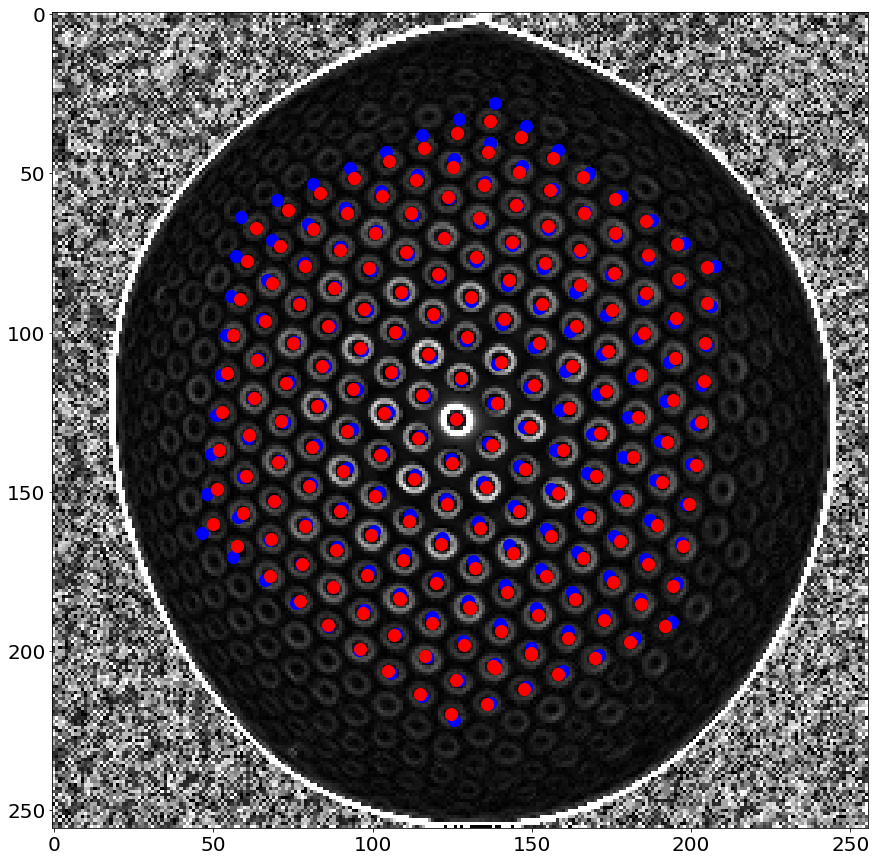

In [21]:
# Plot the center positions (red) ansd the cooresponding undistorted positions
new_peak = estimatedPos1(new_params, cell0, sub_peak, cell_coord)
x1 = new_peak[:, 0]
y1 = new_peak[:, 1]
u1 = new_peak[:, 0]-sub_peak[:,0]
v1 = new_peak[:, 1]-sub_peak[:,1]

rgb_frame=cv2.cvtColor(EMData/np.max(EMData)*3, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(15,15))
plt.imshow(rgb_frame)
plt.plot(y1,x1,'blue',marker = 'o',linestyle = '',markersize = 12)
plt.plot(sub_peak[:,1],sub_peak[:,0],'red',marker = 'o',linestyle = '',markersize = 12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#if you want to check the displacement, use the below code 
#plt.quiver(y1,x1,-v1,u1, color = 'blue', scale = 100, width = 0.003, headwidth =3 )
#plt.axis('off')

### Step 2.3 Fit Zernike model 

In [22]:
# To avoid the influence of the circular edge of the Zernike terms, the image should be put into the center of a larger image.
# Change the size of the new image to get better fitting results 

In [48]:
# Get a large image
lgsz = 420  # Size of the new image
img_large = np.zeros((lgsz, lgsz))  # Initialize a large image with zeros

# Calculate the starting and ending indices to center the gray image in the large image
startx = int((lgsz - gray.shape[0]) / 2)
endx = int(lgsz - (lgsz - gray.shape[0]) / 2)
starty = int((lgsz - gray.shape[1]) / 2)
endy = int(lgsz - (lgsz - gray.shape[1]) / 2)

# Place the gray image in the center of the large image
img_large[startx:endx, starty:endy] = gray

# Calculate the center position of the EMData image
x_pos = EMData.shape[0] / 2
y_pos = EMData.shape[1] / 2

# Initialize maps and aberration arrays with zeros
mapx = np.zeros(gray.shape)
mapy = np.zeros(gray.shape)
aber_x = np.zeros(gray.shape)
aber_y = np.zeros(gray.shape)

# Calculate aberrations for each sub-peak within a radius of 40 from the center of EMData
for i in range(sub_peak.shape[0]):
    if np.sqrt(np.sum((sub_peak[i] - [y_pos, x_pos])**2)) < 40:
        # Calculate the aberrations in x and y directions
        aber_x[int(new_peak[i, 0]), int(new_peak[i, 1])] = sub_peak[i, 0] - new_peak[i, 0]
        aber_y[int(new_peak[i, 0]), int(new_peak[i, 1])] = sub_peak[i, 1] - new_peak[i, 1]

# Initialize large aberration arrays with zeros
aber_x_l = np.zeros(img_large.shape)
aber_y_l = np.zeros(img_large.shape)

# Place the small aberration arrays in the corresponding position of the large aberration arrays
aber_x_l[startx:endx, starty:endy] = aber_x
aber_y_l[startx:endx, starty:endy] = aber_y
#gray = img_large

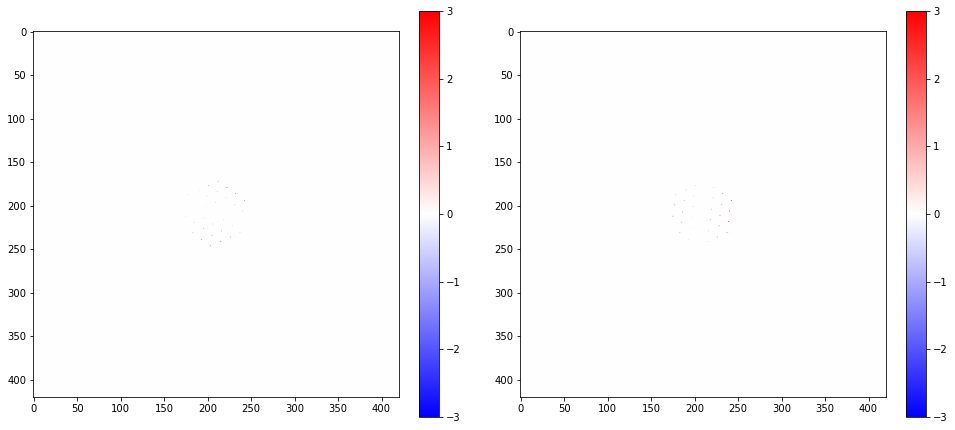

In [49]:
fig =plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(aber_x_l, cmap=plt.cm.bwr, vmax = 3, vmin = -3)
plt.colorbar(fraction = 0.05)
plt.subplot(1, 2, 2)
plt.imshow(aber_y_l, cmap=plt.cm.bwr,vmax = 3, vmin = -3)
plt.colorbar(fraction = 0.05)

In [50]:
# Function to sum Zernike polynomial terms
# znparams: array of Zernike polynomial coefficients
# Zern: array of Zernike polynomials
def SumZern(znparams, Zern):
    # Initialize an array to hold the sum of Zernike polynomials
    Zern_sum = np.zeros(img_large.shape)
    
    # Sum the Zernike polynomial terms using the coefficients
    for i in range(cart.nk):
        Zern_sum += znparams[i] * Zern[:, :, i]
    
    # Replace any NaN values in the sum with 0
    Zern_sum[np.isnan(Zern_sum)] = 0
    
    return Zern_sum

# Function to calculate the total error using fewer points for Zernike polynomial fitting
# znparams: array of Zernike polynomial coefficients
# Zernx: array of Zernike polynomials for the x-direction
# Zerny: array of Zernike polynomials for the y-direction
# aber_x_l: array of aberrations in the x-direction
# aber_y_l: array of aberrations in the y-direction
def ZernTFLessPoints(znparams, Zernx, Zerny, aber_x_l, aber_y_l):
    # Sum the Zernike polynomial terms for the x-direction
    Zernx_sum = SumZern(znparams, Zernx)
    
    # Sum the Zernike polynomial terms for the y-direction
    Zerny_sum = SumZern(znparams, Zerny)
    
    # Calculate the total error using the mask
    error = np.sum(((Zernx_sum - aber_x_l) * mask_p) ** 2) + np.sum(((Zerny_sum - aber_y_l) * mask_p) ** 2)
    
    # Append the calculated error to the error list
    error_list.append(error)
    
    return error

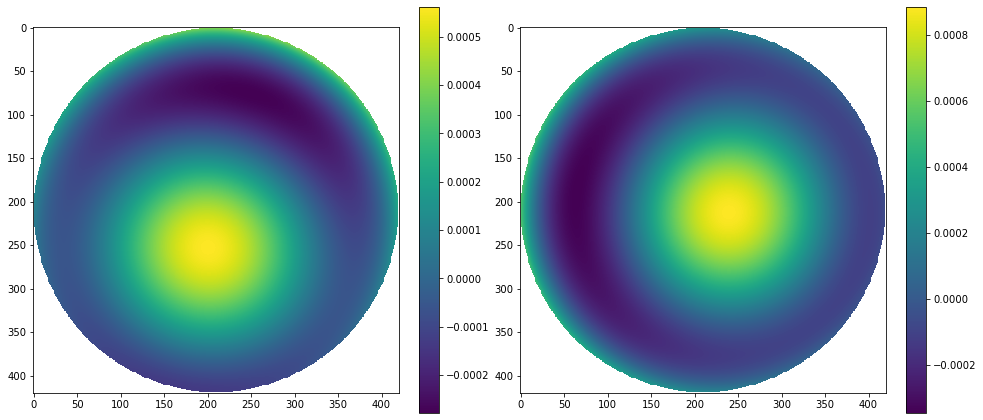

In [51]:
# Get Zernike terms from the pakage
# Initialize an instance of the RZern class with order 4
cart = RZern(4)

# Get the dimensions of the large image
L, K = img_large.shape

# Generate linearly spaced values between -1 and 1 for both dimensions
ddx = np.linspace(-1, 1, K)
ddy = np.linspace(-1, 1, L)

# Create a meshgrid from the linearly spaced values
xv, yv = np.meshgrid(ddx, ddy)

# Create a Cartesian grid using the meshgrid coordinates
cart.make_cart_grid(xv, yv)

# Fit the aberration data for the x-direction to the Cartesian grid and get the coefficients
cx = cart.fit_cart_grid(aber_x_l)[0]

# Evaluate the Zernike polynomial on the grid for the x-direction aberrations
Phi_x = cart.eval_grid(cx, matrix=True)

# Fit the aberration data for the y-direction to the Cartesian grid and get the coefficients
cy = cart.fit_cart_grid(aber_y_l)[0]

# Evaluate the Zernike polynomial on the grid for the y-direction aberrations
Phi_y = cart.eval_grid(cy, matrix=True)


fig =plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(Phi_x)
plt.colorbar(fraction = 0.05)
plt.subplot(1, 2, 2)
plt.imshow(Phi_y)
plt.colorbar(fraction = 0.05)

In [52]:
# Initialize an array for Zernike polynomial coefficients
c = np.zeros(cart.nk)

# Initialize an array to hold the Zernike polynomials for each term
Zern_list = np.zeros((cart.nk, L, K))

# Loop over each Zernike polynomial term
for i in range(cart.nk):
    # Reset the coefficients array
    c *= 0.0
    c[i] = 1.0
    
    # Evaluate the Zernike polynomial for the current term
    Phi = cart.eval_grid(c, matrix=True)
    
    # Replace any NaN values in the polynomial with 0
    Phi[np.isnan(Phi)] = 0
    
    # Store the evaluated polynomial in the list
    Zern_list[i] = Phi

# Initialize a mask for the large image
mask = np.zeros(img_large.shape)

# Create indices for the large image
imgX, imgY = np.indices(img_large.shape)

# Define the center of the large image
x_center = img_large.shape[0] / 2
y_center = img_large.shape[1] / 2

# Create a circular mask within the large image
mask[np.where(np.sqrt((imgX - x_center)**2 + (imgY - y_center)**2) < img_large.shape[0] / 2 - 3)] = 1
mask[np.where(np.sqrt((imgX - x_center)**2 + (imgY - y_center)**2) >= img_large.shape[1] / 2 - 3)] = np.nan

# Initialize arrays for gradients of Zernike polynomials
Zernx = np.zeros((img_large.shape[0], img_large.shape[1], cart.nk))
Zerny = np.zeros((img_large.shape[0], img_large.shape[1], cart.nk))
vZernx = np.zeros((img_large.size, cart.nk))
vZerny = np.zeros((img_large.size, cart.nk))

# Calculate the gradients of each Zernike polynomial term and apply the mask
for i in range(cart.nk):
    # Calculate the gradients in x and y directions
    zernxn, zernyn = np.gradient(Zern_list[i])
    
    # Apply the mask to the gradients and store them
    Zernx[:, :, i] = zernxn * mask
    Zerny[:, :, i] = zernyn * mask
    
    # Flatten the masked gradients and store them in vector form
    vZernx[:, i] = np.ravel(zernxn * mask, order='F')
    vZerny[:, i] = np.ravel(zernyn * mask, order='F')

# Create a mask for the fitting region based on non-zero aberration values
mask_p = np.zeros(img_large.shape)
mask_p[np.where(aber_x_l != 0)[0], np.where(aber_x_l != 0)[1]] = 1

In [53]:
# Fit the Zernike model

# Initialize Zernike polynomial coefficients array
znparams = np.zeros(cart.nk)

# Initialize a list to store total error lists for each iteration
error_list_total = []

# Set the number of iterations for fitting
iteration_num = 3

# Fit the Zernike model for a specified number of iterations
for i in range(iteration_num):
    # Initialize a list to store error values for the current iteration
    error_list = []
    
    # Optimize the Zernike polynomial coefficients using the Nelder-Mead method
    znparams_new1 = optimize.minimize(ZernTFLessPoints, znparams, args=(Zernx, Zerny, aber_x_l, aber_y_l), method='Nelder-Mead').x
    
    # Update the Zernike polynomial coefficients with the new values
    znparams = znparams_new1
    
    # Append the error list for the current iteration to the total error list
    error_list_total.append(error_list)

# Calculate the displacement maps for x and y directions using the fitted Zernike polynomial coefficients
disp_mapx2 = SumZern(znparams_new1, Zernx)
disp_mapy2 = SumZern(znparams_new1, Zerny)

<function matplotlib.pyplot.show(close=None, block=None)>

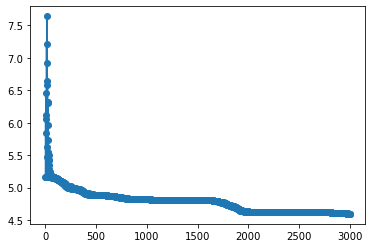

In [54]:
# check the error list to confrim the results are convergent
plt.plot(error_list_total[2],marker = 'o')
plt.show

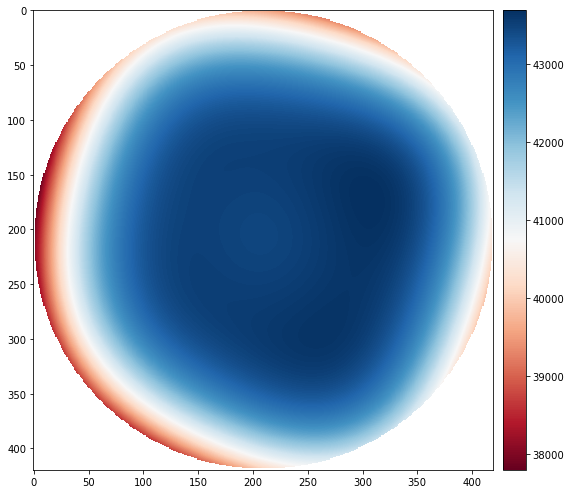

In [55]:
# Check the fitting results
disp_map = cart.eval_grid(znparams_new1, matrix=True)
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(disp_map, cmap=plt.cm.RdBu)
grid.cbar_axes[0].colorbar(im)
#grid[0].set_title("CBED")
#grid[0].axis('off')

Text(0.5, 1.0, 'zerny')

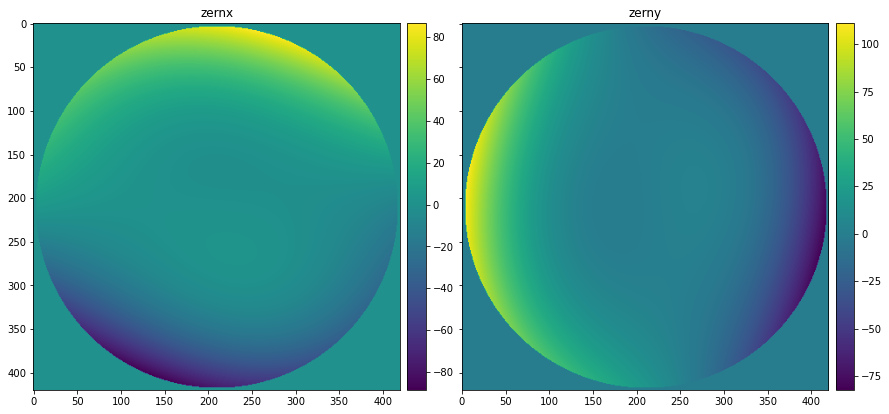

In [56]:
# check the x and y components
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(disp_mapx2, cmap=plt.cm.viridis)
im2=grid[1].imshow(disp_mapy2, cmap=plt.cm.viridis)
#cmap=plt.cm.bwr, vmax = 15, vmin = -15
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("zernx")
grid[1].set_title("zerny")

In [108]:
np.save(folder + "bj_znparams515_order4_450_1.npy",znparams_new1)

In [57]:
# Correct the image distortion by remap based on the model

# Initialize maps for remapping the image based on the displacement model
mapx = np.zeros(img_large.shape)
mapy = np.zeros(img_large.shape)

# Calculate the remapping coordinates for each pixel
for i in range(img_large.shape[0]):
    for j in range(img_large.shape[1]):
        # Calculate the new coordinates based on the displacement maps
        x = i + disp_mapx2[i, j] * 1
        y = j + disp_mapy2[i, j] * 1
        
        # Store the new coordinates in the maps
        mapx[i, j] = x
        mapy[i, j] = y

# Convert the maps to float32 type for remapping
mapx = np.float32(mapx)
mapy = np.float32(mapy)

# Correct the image distortion by remapping the image based on the calculated maps
rst = cv2.remap(img_large, mapy, mapx, cv2.INTER_LINEAR)

Text(0.5, 1.0, 'remap')

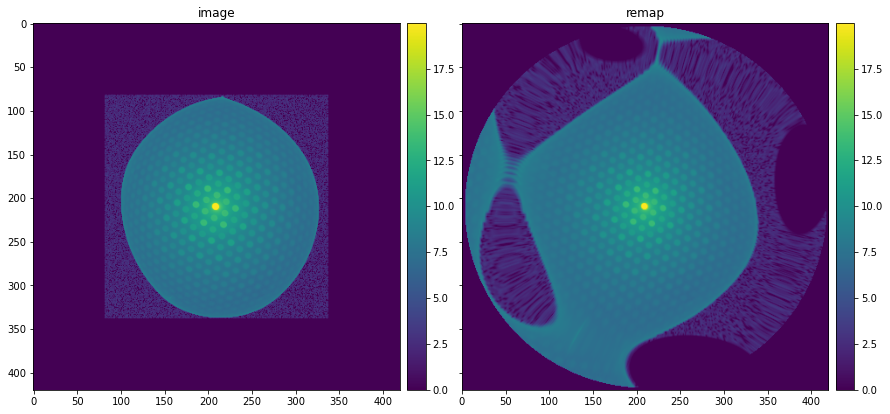

In [58]:
#Check the corrected image
# Adjust the size of the new image to get better reuslts
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(img_large, cmap=plt.cm.viridis)
im2=grid[1].imshow(rst, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("image")
grid[1].set_title("remap")

In [59]:
# Trim the image into original size
x_start = int(K/2-gray.shape[0]/2) 
y_start = int(K/2-gray.shape[0]/2) 
x_end = int(K/2+gray.shape[0]/2) 
y_end = int(K/2+gray.shape[0]/2) 
new_img = rst[x_start:x_end,y_start:y_end]

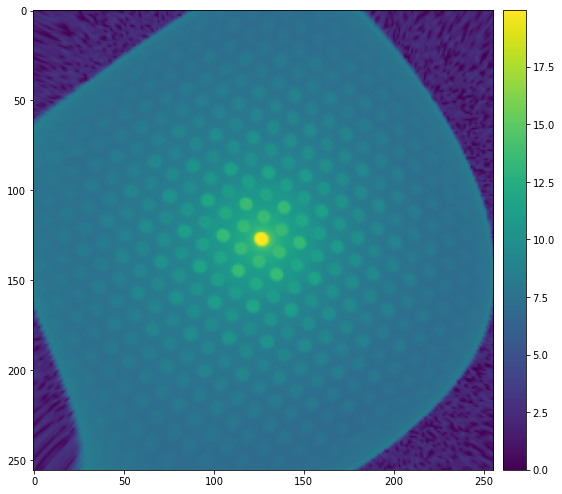

In [60]:
# Check the trimed results
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(new_img, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)

In [55]:
# save the image
np.save(folder+"pacbed_corr.npy", new_img)